# Method 2 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

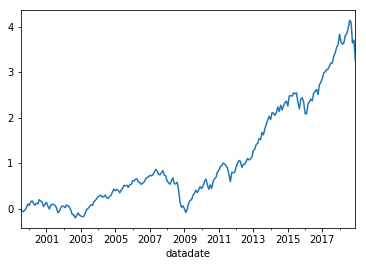

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.099285
2000-12-31   -0.005086
2001-12-31   -0.032566
2002-12-31   -0.192654
2003-12-31    0.426629
2004-12-31    0.171868
2005-12-31    0.072342
2006-12-31    0.107185
2007-12-31    0.014816
2008-12-31   -0.384881
2009-12-31    0.401025
2010-12-31    0.215358
2011-12-31   -0.003114
2012-12-31    0.188622
2013-12-31    0.417670
2014-12-31    0.109982
2015-12-31   -0.005965
2016-12-31    0.130401
2017-12-31    0.218355
2018-12-31   -0.078853
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2923.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.26e-195
Time:                        03:30:54   Log-Likelihood:                 850.43
No. Observations:                 234   AIC:                            -1691.
Df Residuals:                     229   BIC:                            -1674.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.984      0.000       0.001       0.003
mktrf          0.9899      0.012     82.186      0.000       0.966       1.014
me             0.2409      0.014     17.192      0.000       0.213       0.268
ia             0.0960      0.021      4.510      0.000       0.054       0.138
roe           -0.0041      0.018     -0.225      0.822      -0.040       0.032
==============================================================================
Omnibus:                       25.656   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.030
Skew:                           0.037   Prob(JB):                     2.61e-28
Kurtosis:                       6.609   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1423.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.05e-160
Time:                        03:30:54   Log-Likelihood:                 850.43
No. Observations:                 234   AIC:                            -1691.
Df Residuals:                     229   BIC:                            -1674.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.657      0.000       0.001       0.003
mktrf          0.9899      0.016     62.765      0.000       0.959       1.021
me             0.2409      0.029      8.449      0.000       0.185       0.297
ia             0.0960      0.045      2.139      0.032       0.008       0.184
roe           -0.0041      0.023     -0.179      0.858      -0.049       0.041
==============================================================================
Omnibus:                       25.656   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.030
Skew:                           0.037   Prob(JB):                     2.61e-28
Kurtosis:                       6.609   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1695.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.33e-169
Time:                        03:30:54   Log-Likelihood:                 850.43
No. Observations:                 234   AIC:                            -1691.
Df Residuals:                     229   BIC:                            -1674.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.049      0.000       0.001       0.003
mktrf          0.9899      0.015     65.327      0.000       0.960       1.020
me             0.2409      0.027      8.923      0.000       0.188       0.294
ia             0.0960      0.051      1.899      0.058      -0.003       0.195
roe           -0.0041      0.025     -0.163      0.870      -0.053       0.045
==============================================================================
Omnibus:                       25.656   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.030
Skew:                           0.037   Prob(JB):                     2.61e-28
Kurtosis:                       6.609   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2137.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.75e-189
Time:                        03:30:54   Log-Likelihood:                 840.59
No. Observations:                 234   AIC:                            -1669.
Df Residuals:                     228   BIC:                            -1648.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.022      0.000       0.001       0.003
mktrf          1.0033      0.013     79.536      0.000       0.978       1.028
smb            0.2693      0.017     16.178      0.000       0.236       0.302
hml            0.0263      0.020      1.340      0.182      -0.012       0.065
rmw            0.0280      0.022      1.262      0.208      -0.016       0.072
cma            0.0657      0.028      2.330      0.021       0.010       0.121
==============================================================================
Omnibus:                       36.587   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.531
Skew:                           0.284   Prob(JB):                     1.31e-53
Kurtosis:                       7.965   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1208.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.77e-162
Time:                        03:30:54   Log-Likelihood:                 840.59
No. Observations:                 234   AIC:                            -1669.
Df Residuals:                     228   BIC:                            -1648.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.995      0.000       0.001       0.003
mktrf          1.0033      0.016     64.066      0.000       0.973       1.034
smb            0.2693      0.025     10.732      0.000       0.220       0.318
hml            0.0263      0.046      0.571      0.568      -0.064       0.117
rmw            0.0280      0.024      1.181      0.238      -0.018       0.074
cma            0.0657      0.042      1.553      0.121      -0.017       0.149
==============================================================================
Omnibus:                       36.587   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.531
Skew:                           0.284   Prob(JB):                     1.31e-53
Kurtosis:                       7.965   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1663.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.53e-177
Time:                        03:30:54   Log-Likelihood:                 840.59
No. Observations:                 234   AIC:                            -1669.
Df Residuals:                     228   BIC:                            -1648.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.133      0.000       0.001       0.003
mktrf          1.0033      0.014     69.705      0.000       0.975       1.031
smb            0.2693      0.025     10.894      0.000       0.221       0.318
hml            0.0263      0.050      0.524      0.600      -0.072       0.125
rmw            0.0280      0.027      1.046      0.296      -0.024       0.080
cma            0.0657      0.042      1.579      0.114      -0.016       0.147
==============================================================================
Omnibus:                       36.587   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.531
Skew:                           0.284   Prob(JB):                     1.31e-53
Kurtosis:                       7.965   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2350.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.37e-184
Time:                        03:30:54   Log-Likelihood:                 825.44
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     229   BIC:                            -1624.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000      4.799      0.000       0.001       0.003
mktrf          0.9851      0.012     79.831      0.000       0.961       1.009
smb            0.2473      0.015     16.056      0.000       0.217       0.278
hml            0.1099      0.015      7.186      0.000       0.080       0.140
umd           -0.0096      0.010     -0.959      0.339      -0.029       0.010
==============================================================================
Omnibus:                       36.326   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.659
Skew:                           0.318   Prob(JB):                     9.97e-50
Kurtosis:                       7.769   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1317.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.70e-157
Time:                        03:30:54   Log-Likelihood:                 825.44
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     229   BIC:                            -1624.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.907      0.000       0.001       0.003
mktrf          0.9851      0.019     52.217      0.000       0.948       1.022
smb            0.2473      0.026      9.694      0.000       0.197       0.297
hml            0.1099      0.050      2.179      0.029       0.011       0.209
umd           -0.0096      0.019     -0.519      0.604      -0.046       0.027
==============================================================================
Omnibus:                       36.326   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.659
Skew:                           0.318   Prob(JB):                     9.97e-50
Kurtosis:                       7.769   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1720.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.61e-169
Time:                        03:30:54   Log-Likelihood:                 825.44
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     229   BIC:                            -1624.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.891      0.000       0.001       0.003
mktrf          0.9851      0.017     57.983      0.000       0.952       1.018
smb            0.2473      0.027      9.281      0.000       0.195       0.300
hml            0.1099      0.058      1.898      0.058      -0.004       0.223
umd           -0.0096      0.015     -0.662      0.508      -0.038       0.019
==============================================================================
Omnibus:                       36.326   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.659
Skew:                           0.318   Prob(JB):                     9.97e-50
Kurtosis:                       7.769   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1329.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.06e-95
Time:                        03:30:54   Log-Likelihood:                 419.48
No. Observations:                 120   AIC:                            -829.0
Df Residuals:                     115   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.646      0.000       0.001       0.004
mktrf          0.9872      0.019     51.089      0.000       0.949       1.025
me             0.2205      0.019     11.556      0.000       0.183       0.258
ia             0.1478      0.030      4.944      0.000       0.089       0.207
roe           -0.0168      0.026     -0.635      0.527      -0.069       0.036
==============================================================================
Omnibus:                       10.479   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.135
Skew:                           0.082   Prob(JB):                     2.11e-06
Kurtosis:                       5.280   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     860.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.12e-84
Time:                        03:30:54   Log-Likelihood:                 419.48
No. Observations:                 120   AIC:                            -829.0
Df Residuals:                     115   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.258      0.001       0.001       0.004
mktrf          0.9872      0.026     38.073      0.000       0.936       1.038
me             0.2205      0.029      7.571      0.000       0.163       0.278
ia             0.1478      0.044      3.346      0.001       0.061       0.234
roe           -0.0168      0.027     -0.633      0.527      -0.069       0.035
==============================================================================
Omnibus:                       10.479   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.135
Skew:                           0.082   Prob(JB):                     2.11e-06
Kurtosis:                       5.280   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1424.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.38e-97
Time:                        03:30:54   Log-Likelihood:                 419.48
No. Observations:                 120   AIC:                            -829.0
Df Residuals:                     115   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.334      0.001       0.001       0.004
mktrf          0.9872      0.022     44.212      0.000       0.943       1.031
me             0.2205      0.028      7.818      0.000       0.165       0.276
ia             0.1478      0.044      3.380      0.001       0.062       0.233
roe           -0.0168      0.027     -0.616      0.538      -0.070       0.037
==============================================================================
Omnibus:                       10.479   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.135
Skew:                           0.082   Prob(JB):                     2.11e-06
Kurtosis:                       5.280   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     905.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.77e-90
Time:                        03:30:54   Log-Likelihood:                 410.54
No. Observations:                 120   AIC:                            -809.1
Df Residuals:                     114   BIC:                            -792.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.374      0.001       0.001       0.004
mktrf          1.0312      0.022     46.775      0.000       0.988       1.075
smb            0.2667      0.025     10.681      0.000       0.217       0.316
hml            0.0141      0.031      0.460      0.647      -0.047       0.075
rmw            0.0496      0.036      1.374      0.172      -0.022       0.121
cma            0.1287      0.040      3.255      0.001       0.050       0.207
==============================================================================
Omnibus:                       19.831   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.431
Skew:                           0.282   Prob(JB):                     6.27e-20
Kurtosis:                       7.168   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     761.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.12e-86
Time:                        03:30:54   Log-Likelihood:                 410.54
No. Observations:                 120   AIC:                            -809.1
Df Residuals:                     114   BIC:                            -792.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.241      0.001       0.001       0.004
mktrf          1.0312      0.029     35.007      0.000       0.974       1.089
smb            0.2667      0.037      7.126      0.000       0.193       0.340
hml            0.0141      0.074      0.189      0.850      -0.132       0.160
rmw            0.0496      0.051      0.976      0.329      -0.050       0.149
cma            0.1287      0.050      2.565      0.010       0.030       0.227
==============================================================================
Omnibus:                       19.831   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.431
Skew:                           0.282   Prob(JB):                     6.27e-20
Kurtosis:                       7.168   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1176.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.69e-96
Time:                        03:30:54   Log-Likelihood:                 410.54
No. Observations:                 120   AIC:                            -809.1
Df Residuals:                     114   BIC:                            -792.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.488      0.000       0.001       0.004
mktrf          1.0312      0.027     38.560      0.000       0.979       1.084
smb            0.2667      0.038      7.083      0.000       0.193       0.341
hml            0.0141      0.081      0.173      0.863      -0.145       0.173
rmw            0.0496      0.056      0.879      0.380      -0.061       0.160
cma            0.1287      0.050      2.578      0.010       0.031       0.226
==============================================================================
Omnibus:                       19.831   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.431
Skew:                           0.282   Prob(JB):                     6.27e-20
Kurtosis:                       7.168   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     955.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.25e-87
Time:                        03:30:54   Log-Likelihood:                 400.18
No. Observations:                 120   AIC:                            -790.4
Df Residuals:                     115   BIC:                            -776.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.099      0.000       0.002       0.005
mktrf          0.9845      0.020     49.246      0.000       0.945       1.024
smb            0.2457      0.023     10.794      0.000       0.201       0.291
hml            0.1384      0.023      6.072      0.000       0.093       0.184
umd           -0.0140      0.014     -0.999      0.320      -0.042       0.014
==============================================================================
Omnibus:                       17.889   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.711
Skew:                           0.256   Prob(JB):                     4.42e-16
Kurtosis:                       6.726   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     893.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.44e-85
Time:                        03:30:54   Log-Likelihood:                 400.18
No. Observations:                 120   AIC:                            -790.4
Df Residuals:                     115   BIC:                            -776.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.022      0.000       0.002       0.005
mktrf          0.9845      0.031     32.099      0.000       0.924       1.045
smb            0.2457      0.028      8.675      0.000       0.190       0.301
hml            0.1384      0.062      2.232      0.026       0.017       0.260
umd           -0.0140      0.021     -0.654      0.513      -0.056       0.028
==============================================================================
Omnibus:                       17.889   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.711
Skew:                           0.256   Prob(JB):                     4.42e-16
Kurtosis:                       6.726   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1540.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.82e-99
Time:                        03:30:54   Log-Likelihood:                 400.18
No. Observations:                 120   AIC:                            -790.4
Df Residuals:                     115   BIC:                            -776.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.265      0.000       0.002       0.005
mktrf          0.9845      0.025     40.020      0.000       0.936       1.033
smb            0.2457      0.030      8.110      0.000       0.186       0.305
hml            0.1384      0.068      2.028      0.043       0.005       0.272
umd           -0.0140      0.017     -0.841      0.400      -0.047       0.019
==============================================================================
Omnibus:                       17.889   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.711
Skew:                           0.256   Prob(JB):                     4.42e-16
Kurtosis:                       6.726   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2610.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.24e-107
Time:                        03:30:54   Log-Likelihood:                 464.44
No. Observations:                 114   AIC:                            -918.9
Df Residuals:                     109   BIC:                            -905.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.487      0.000       0.001       0.003
mktrf          0.9920      0.012     80.166      0.000       0.967       1.017
me             0.2857      0.019     14.954      0.000       0.248       0.324
ia            -0.0668      0.027     -2.520      0.013      -0.119      -0.014
roe           -0.0417      0.023     -1.791      0.076      -0.088       0.004
==============================================================================
Omnibus:                        8.825   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.946
Skew:                          -0.553   Prob(JB):                       0.0114
Kurtosis:                       3.813   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3886.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.49e-116
Time:                        03:30:54   Log-Likelihood:                 464.44
No. Observations:                 114   AIC:                            -918.9
Df Residuals:                     109   BIC:                            -905.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.314      0.000       0.001       0.003
mktrf          0.9920      0.009    106.615      0.000       0.974       1.010
me             0.2857      0.018     15.952      0.000       0.251       0.321
ia            -0.0668      0.029     -2.298      0.022      -0.124      -0.010
roe           -0.0417      0.022     -1.854      0.064      -0.086       0.002
==============================================================================
Omnibus:                        8.825   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.946
Skew:                          -0.553   Prob(JB):                       0.0114
Kurtosis:                       3.813   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5209.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.91e-123
Time:                        03:30:54   Log-Likelihood:                 464.44
No. Observations:                 114   AIC:                            -918.9
Df Residuals:                     109   BIC:                            -905.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.122      0.000       0.001       0.003
mktrf          0.9920      0.009    114.723      0.000       0.975       1.009
me             0.2857      0.019     15.081      0.000       0.249       0.323
ia            -0.0668      0.033     -2.044      0.041      -0.131      -0.003
roe           -0.0417      0.021     -2.033      0.042      -0.082      -0.002
==============================================================================
Omnibus:                        8.825   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.946
Skew:                          -0.553   Prob(JB):                       0.0114
Kurtosis:                       3.813   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3520.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.78e-118
Time:                        03:30:54   Log-Likelihood:                 494.48
No. Observations:                 114   AIC:                            -977.0
Df Residuals:                     108   BIC:                            -960.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      3.400      0.001       0.000       0.002
mktrf          0.9947      0.009    109.186      0.000       0.977       1.013
smb            0.2570      0.015     17.378      0.000       0.228       0.286
hml            0.0026      0.019      0.135      0.893      -0.035       0.040
rmw           -0.1145      0.023     -4.960      0.000      -0.160      -0.069
cma           -0.0899      0.029     -3.067      0.003      -0.148      -0.032
==============================================================================
Omnibus:                       10.873   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.202
Skew:                          -0.669   Prob(JB):                      0.00369
Kurtosis:                       3.755   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3232.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.51e-116
Time:                        03:30:54   Log-Likelihood:                 494.48
No. Observations:                 114   AIC:                            -977.0
Df Residuals:                     108   BIC:                            -960.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      3.114      0.002       0.000       0.002
mktrf          0.9947      0.009    113.452      0.000       0.977       1.012
smb            0.2570      0.014     18.658      0.000       0.230       0.284
hml            0.0026      0.015      0.165      0.869      -0.028       0.033
rmw           -0.1145      0.019     -5.895      0.000      -0.153      -0.076
cma           -0.0899      0.029     -3.086      0.002      -0.147      -0.033
==============================================================================
Omnibus:                       10.873   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.202
Skew:                          -0.669   Prob(JB):                      0.00369
Kurtosis:                       3.755   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4597.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.61e-124
Time:                        03:30:54   Log-Likelihood:                 494.48
No. Observations:                 114   AIC:                            -977.0
Df Residuals:                     108   BIC:                            -960.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.788      0.005       0.000       0.002
mktrf          0.9947      0.008    128.061      0.000       0.979       1.010
smb            0.2570      0.012     21.044      0.000       0.233       0.281
hml            0.0026      0.012      0.206      0.837      -0.022       0.027
rmw           -0.1145      0.021     -5.563      0.000      -0.155      -0.074
cma           -0.0899      0.028     -3.260      0.001      -0.144      -0.036
==============================================================================
Omnibus:                       10.873   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.202
Skew:                          -0.669   Prob(JB):                      0.00369
Kurtosis:                       3.755   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3178.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.97e-112
Time:                        03:30:54   Log-Likelihood:                 475.54
No. Observations:                 114   AIC:                            -941.1
Df Residuals:                     109   BIC:                            -927.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.016      0.046    1.31e-05       0.002
mktrf          1.0056      0.011     94.524      0.000       0.984       1.027
smb            0.2828      0.017     17.049      0.000       0.250       0.316
hml           -0.0017      0.017     -0.099      0.921      -0.036       0.032
umd           -0.0112      0.013     -0.871      0.385      -0.037       0.014
==============================================================================
Omnibus:                        8.834   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.682
Skew:                          -0.589   Prob(JB):                       0.0130
Kurtosis:                       3.664   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1859.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.82e-99
Time:                        03:30:54   Log-Likelihood:                 475.54
No. Observations:                 114   AIC:                            -941.1
Df Residuals:                     109   BIC:                            -927.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.758      0.079    -8.8e-05       0.002
mktrf          1.0056      0.012     81.261      0.000       0.981       1.030
smb            0.2828      0.015     18.612      0.000       0.253       0.313
hml           -0.0017      0.014     -0.119      0.906      -0.030       0.026
umd           -0.0112      0.009     -1.267      0.205      -0.029       0.006
==============================================================================
Omnibus:                        8.834   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.682
Skew:                          -0.589   Prob(JB):                       0.0130
Kurtosis:                       3.664   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2083.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.24e-102
Time:                        03:30:54   Log-Likelihood:                 475.54
No. Observations:                 114   AIC:                            -941.1
Df Residuals:                     109   BIC:                            -927.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.718      0.086      -0.000       0.002
mktrf          1.0056      0.012     83.033      0.000       0.982       1.029
smb            0.2828      0.012     22.728      0.000       0.258       0.307
hml           -0.0017      0.011     -0.151      0.880      -0.024       0.020
umd           -0.0112      0.009     -1.297      0.195      -0.028       0.006
==============================================================================
Omnibus:                        8.834   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.682
Skew:                          -0.589   Prob(JB):                       0.0130
Kurtosis:                       3.664   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""